# Regression
Regression is fundamentally a way to estimate an independent variable based on its relationships to predictor variables. This can be done both linearly and non-linearly with a single to many predictor variables. However, there are certain assumptions that must be satisfied in order for these results to be trustworthy.

In [2]:
#Import Packages
import numpy as np
import pandas as pd

#Plotting
import seaborn as sns
sns.set(rc={'figure.figsize':(11,8)})
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as ticker

#Stats
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
import statistics

## Linear Regression

Recall $y=mx+b$, in this case we can see that $y$ is defined by a pair of constants and $x$. Similarly in regression, we have our independent target variable being estimated by a set of derived constants and the input variable(s). Since what comes out of the model is not necessarily what was observed, we call the prediction of the model $\hat{y}$. The equation is then: $\hat{y}=\hat{\beta_0} + \hat{\beta_1}x_1 + ... + \hat{\beta_1}x_n + \epsilon$ for n predictors, where the $\hat{\beta_i}$ are the estimated coefficients and constant.

In the case of linear regression, the line will have the equation:$\hat{y}=\hat{\beta_0}+\hat{\beta_1}x_1+\epsilon$, with $\epsilon$ being the distance between the observation and the prediction, i.e. $y-\hat{y}$.

Now the question is "how do we determine what the $\hat{\beta_0}\ ...\ \hat{\beta_n}$ should be?" or rather "how can we manipulate the $\hat{\beta_0}\ ...\ \hat{\beta_n}$ to minimize error?"

$\epsilon$ is defined as the difference between reality and prediction, so minimizing this distance by itself would be a good starting place. However, since we generally want to increase punishment to the algorithm for missing points by a large margin, $punishment = (y-\hat{y})^2 = \epsilon^2$ is used. More formally, for a series of $m$ data points, the Sum of Squared Errors is defined as follows: $SSE=\sum_{i=1}^{m}(y_i-\hat{y_i})^2$ for $m$ predictions. This makes the Mean Squared Error $\frac{SSE}{m}=MSE$. So, if we minimize mean squared error ($MSE$) we find the optimal line.

In [6]:
#Create a function to predict our line
def predict(x,slope,intercept):
    return (slope*x+intercept)

In [ ]:
#Generate Data
X = np.random.uniform(10,size=10)
Y = list(map(lambda x: x+ 2*np.random.randn(1)[0], X)) #f(x) = x + 2N

#Graph Cloud
sns.relplot(x='X', y='Y', data=pd.DataFrame({'X':X,'Y':Y}),color='darkblue', zorder=10)

Now, with a regression line

In [ ]:
#Get Regression Results
slope, intercept, r_value, p_value, std_err = stats.linregress(X,Y)

#Create Regression Line
lx = [min(X)-1,max(X)+1] #X-Bounds
ly = [predict(lx[0],slope,intercept),predict(lx[1],slope,intercept)] #Predictions at Bounds

#Graph
sns.relplot(x='X', y='Y', data=pd.DataFrame({'X':X,'Y':Y}),color='darkblue', zorder=10)
sns.lineplot(lx, ly, color='r', zorder=5)

Then, find the $y_i-\hat{y_i}$

In [ ]:
#Plot Background
sns.relplot(x='X', y='Y', data=pd.DataFrame({'X':X,'Y':Y}),color='darkblue', zorder=10)
sns.lineplot(lx, ly, color='r', zorder=5)

#Plot Distances
for i in range(len(X)):
    plt.plot([X[i],X[i]],[Y[i],predict(X[i],slope,intercept)],color = 'royalblue',linestyle=':',zorder=0)

Finally, calculate the MSE

In [ ]:
#Setup
fig, axs = plt.subplots(ncols=3, figsize=(15,5))

#Calculations
xy = pd.DataFrame({'X':X,'Y':Y}).sort_values('Y')
xy['Y`'] = list(map(lambda x,y: ((predict(x,slope,intercept))), xy['X'], xy['Y']))
xy['E'] = abs(xy['Y'] - xy['Y`'])
xy = xy.sort_values(by=['E'])

#Plot First Graph
for i in range(len(xy)):
    axs[0].plot([i,i],[0,xy.iloc[i,3]], color='royalblue',linestyle='-')
axs[0].set_title('Sorted Errors')

#Plot Second Graph
for i in range(len(xy)):
    axs[1].plot([i,i],[0,xy.iloc[i,3]**2], color='royalblue',linestyle='-')
axs[1].set_title('Sorted Squared Errors')

#Plot Third Graph
total = min(xy['E'])
for i in range(len(xy)):
    deltah = xy.iloc[i,3]**2
    axs[2].plot([i,i],[0,xy.iloc[i,3]**2], color='royalblue',linestyle='-')
    axs[2].plot([max(0,i-1),i],[total,total + deltah], color='red',linestyle='-',marker='o')
    total+=deltah
axs[2].set_title('Running Sum of Squared Erros')
plt.show()

#Calculate MSE
MSE = statistics.mean(list(map(lambda e: e**2, xy['E'])))
print('Sum of Squared Errors:',round(total-min(xy['E']),3))
print('Total Observations:',len(xy))
print('Mean Squared Error:',round(MSE,4))

Now that we have a measure of success, we would like to develop some intuition and a function for how good we are predicting relative to perfect. If we were to imagine a straight line exactly through the mean of the Y-value (target value) of the cloud, we can imagine that half the points are above and half below. This calculation would give an $SSE$ of $\sum_{i=1}^{n}(y_i-\bar{y_i})^2$, or how this will be defined hereon the $SST$ or Sum of Squared Total Error. This guess is assumed to be the baseline guess you can make, and anything better is considered to be an improvement. As such, the ratio of $\frac{SSE}{SST}$ models success relative to a benchmark. Functioning under the assumption that $0\leq SSE\leq SST$, $1-\frac{SSE}{SST}$ gives a [0,1] interval of success generally known as $R^2$.

Let's calculate.

In [ ]:
#Create Data, Figures
X = np.random.uniform(10,size=10)
Y = list(map(lambda x: x+ len(X)/10*np.random.randn(1)[0], X))
avgy = statistics.mean(Y)
fig, axs = plt.subplots(ncols=2,figsize=(10,5))

#Calculate Regressions
slope, intercept, r_value, p_value, std_err = stats.linregress(X,Y)
lx = [min(X)-1,max(X)+1]
ly = [predict(lx[0],slope,intercept),predict(lx[1],slope,intercept)]
avgy = statistics.mean(Y)

#Calculate and Format MSE
MSEr = 'MSE: '+str(round(statistics.mean(list(map(lambda x, y: (y-(predict(x,slope,intercept)))**2, X, Y))),3))
MSEa = 'MSE: '+str(round(statistics.mean(list(map(lambda y: (y-avgy)**2, Y))),3))

#Create Scatter And Lines
axs[0].scatter(X,Y, color='darkblue', zorder=10)
axs[1].scatter(X,Y, color='darkblue', zorder=10)
axs[0].plot(lx, ly, color='r', zorder=5, label=MSEr)
axs[1].plot(lx, [avgy,avgy], color='lightslategray', label=MSEa)

#Create Dotted Lines
for i in range(len(X)):
    axs[0].plot([X[i],X[i]],[Y[i],predict(X[i],slope,intercept)],color = 'red',linestyle=':',zorder=0)
    axs[1].plot([X[i],X[i]],[Y[i],avgy],color = 'dimgray',linestyle=':',zorder=0)  

#Calculate R2
R2r = 'Linear Regression: R-squared = '+str(round(r_value,3))
SSTa = sum(list(map(lambda y: (y-statistics.mean(Y))**2, Y)))
SSEa = sum(list(map(lambda y: (y-statistics.mean(Y))**2, Y)))
R2a = 'Linear Regression: R-squared = '+str(round(1 - SSEa/SSTa,3))

#Format
axs[0].set(xlabel='X',ylabel='Y',title=R2r)
axs[1].set(xlabel='X',ylabel='Y',title=R2a)
axs[0].legend()
axs[1].legend()

#Paint Graphs
plt.show()

Thankfully, we don't have to do this manually. To repeat this process and get out all the same information automatically, we can use SciPy, a scientific modeling library for python. In this case, as you saw above, we are using the linregress function to solve the linear system of equations that gives us the minimal MSE. Let's see how this would be implemented in practice.

In [ ]:
X = np.random.randn(150).tolist()
Y = list(map(lambda x: x + np.random.randn(1)[0]/1.5, X)) #f(x) = x + N(0,2/3)

reg = stats.linregress(X,Y)
title = 'Linear Regression R-Squared: '+str(round(reg.rvalue,3))

fig = sns.lmplot(x='X',y='Y',data=pd.DataFrame({'X':X,'Y':Y}),ci=False).set(title=title)
fig.ax.get_lines()[0].set_color('red')

However, not all data can be regressed. There are four criterian that must be met in order for the assumptions necessary for regression to be satisfied. These can be generally analyzed through residuals, or $y-\hat{y}$.

1) Linearity

2) Independence

3) Homoscedasticity

4) Normality

We will go through each one a describe how to ensure your data is acceptable.

### Linearity
This is essentially that the relationship between the variables in linear in nature

#### Method 1: Residuals vs. Observed, what you are looking for is any pattern to the data.

In [9]:
#Data
X = np.random.randn(300).tolist()

Text(0.5, 1.0, 'Residuals of Linear Regression: Rejected')

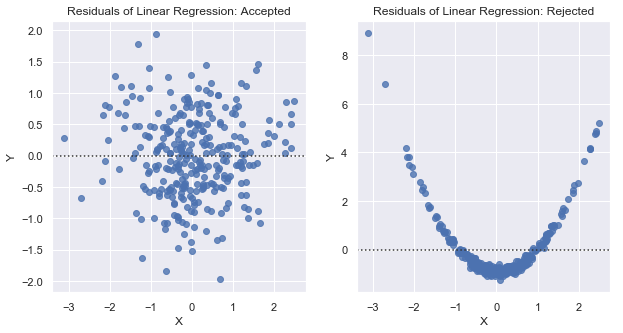

In [10]:
#Setup
fig, axs = plt.subplots(ncols=2,figsize=(10,5))

#Accepted
Y = list(map(lambda x: x + np.random.randn(1)[0]/1.5, X))
sns.residplot(x='X',y='Y',data=pd.DataFrame({'X':X,'Y':Y})
              ,ax=axs[0]).set_title('Residuals of Linear Regression: Accepted')

#Rejected
Y = list(map(lambda x: x**2 + np.random.randn(1)[0]/8, X))
sns.residplot(x='X',y='Y',data=pd.DataFrame({'X':X,'Y':Y})
              ,ax=axs[1], color='b').set_title('Residuals of Linear Regression: Rejected')

#### Method 2: Observed vs. Predicted, looking for patterns

[Text(0.5, 1.0, 'Predictions versus Observations: Rejected')]

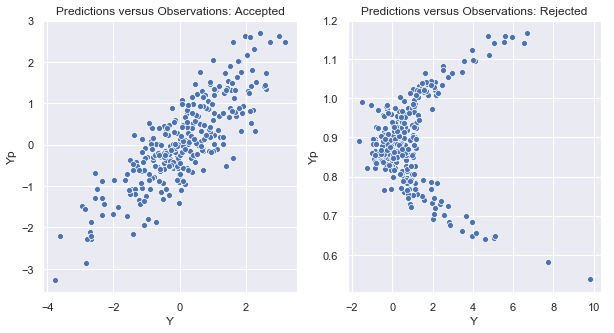

In [11]:
#Setup
fig, axs = plt.subplots(ncols=2,figsize=(10,5))

#Accept
Y = list(map(lambda x: x + np.random.randn(1)[0]/1.5, X))
slope, intercept, r_value, p_value, std_err = stats.linregress(X,Y)
Yp = list(map(lambda x: predict(x,slope,intercept), X))

sns.scatterplot(x='Y',y='Yp',data=pd.DataFrame({'Y':Y,'Yp':Yp}), ax=axs[0])
axs[0].set(title='Predictions versus Observations: Accepted')

#Reject
Y = list(map(lambda x: x**2 + np.random.randn(1)[0]/1.5, X))
slope, intercept, r_value, p_value, std_err = stats.linregress(X,Y)
Yp = list(map(lambda x: predict(x,slope,intercept), X))

sns.scatterplot(x='Y',y='Yp',data=pd.DataFrame({'Y':Y,'Yp':Yp}), ax=axs[1])
axs[1].set(title='Predictions versus Observations: Rejected')

### Independence
This looks at whether the $\epsilon$ is correlated to the predictors either through sorting or other methods. This is a serious consideration for time series data, but we will focus on non-time series for now. 

#### Method 1) Same as above. Compare the order of observations agains the residuals, there should be no pattern

#### Method 2) For more than 1 predictor, use VIF scores to check for multicolinearity amongst the variables
There is no hard and fast rule for kicking variables out due to VIF scores, but a good rule of thumb is anything more than 10 needs should likely need to be dealt with and anything greater than 5 should at least be looked at.

In [ ]:
#Calculate Scores
A = np.random.randn(150).tolist()
B = list(map(lambda a: a + np.random.randn(1)[0]/20, A))
C = np.random.uniform(1,10,size=150).tolist()

data = pd.DataFrame({'A':A,'B':B,'C':C})
data = add_constant(data)

VIFs = pd.DataFrame([variance_inflation_factor(data.values, i) for i in range(data.shape[1])], index=data.columns,
                   columns=['VIF Score'])
print('Accept if less than 5, Reject if more than 10\n')
print(VIFs)

### Homoscedasticity
Check for if the magnitude of the residuals is the same over time or observations

#### Method 1) Ordered Plot

Text(0.5, 1.0, 'Reject')

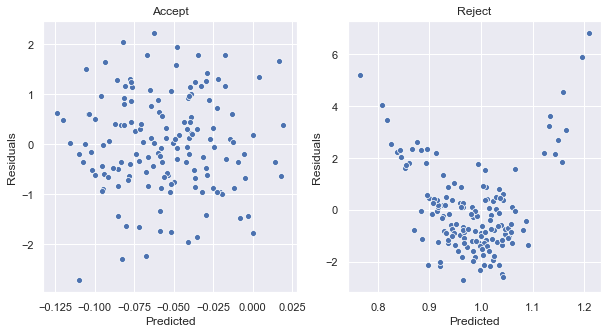

In [12]:
#Setup
fig, axs = plt.subplots(ncols=2,figsize=(10,5))

#Accept
X = np.random.randn(150)
Y = np.random.randn(150)

slope, intercept, r_value, p_value, std_err = stats.linregress(X, Y)
predicted = X*slope+intercept
residuals = np.subtract(Y,predicted)

sns.scatterplot(x='Predicted',y='Residuals', ax = axs[0],
            data=pd.DataFrame({'Predicted':predicted,'Residuals':residuals})).set_title('Accept')

#Reject
X = np.random.randn(150)
Y = list(map(lambda x: x**2 + np.random.randn(1)[0], X))

slope, intercept, r_value, p_value, std_err = stats.linregress(X, Y)
predicted = X*slope+intercept
residuals = np.subtract(Y,predicted)

sns.scatterplot(x='Predicted',y='Residuals', ax = axs[1],
            data=pd.DataFrame({'Predicted':predicted,'Residuals':residuals})).set_title("Reject")

### Normality

#### Method 1) Q-Q Plot

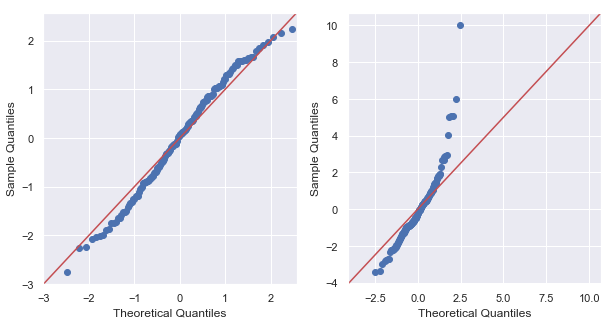

In [13]:
fig, axs = plt.subplots(ncols=2,figsize=(10,5))

#Accept
X = np.random.randn(150)
Y = np.random.randn(150)

slope, intercept, r_value, p_value, std_err = stats.linregress(X, Y)
predicted = X*slope+intercept
residuals = np.subtract(Y,predicted)

sm.qqplot(residuals, line='45',ax=axs[0])

#Reject
X = np.random.randn(150)
Y = list(map(lambda x: x**2 + np.random.randn(1)[0], X))

slope, intercept, r_value, p_value, std_err = stats.linregress(X, Y)
predicted = X*slope+intercept
residuals = np.subtract(Y,predicted)

sm.qqplot(residuals, line='45',ax=axs[1])

plt.show()

## Multiple Regression

This is exactly the same as before, but we can increase the number of predictors. For example, this is what it looks like to perform linear regression in free space, fitting a plane to a cloud of points.

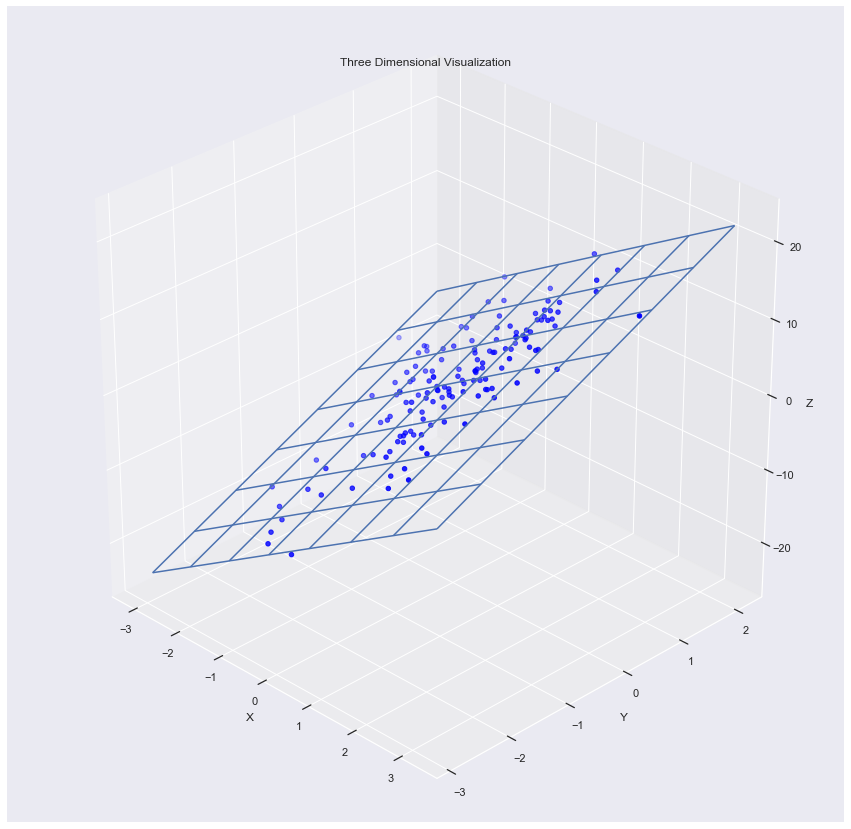

In [3]:
#Generate Data
X = np.random.randn(150)
Y = np.random.randn(150)
Z = list(map(lambda y, x: 4*(y + x) + np.random.randn(1)[0], Y, X))

#Regress
reg = smf.ols(formula='Z ~ X+Y', data=pd.DataFrame({'X':X,'Y':Y,'Z':Z})).fit()

#Calculate Plane
xx = np.linspace(min(X), max(X), 8)
yy = np.linspace(min(Y), max(Y), 8)
XX, YY = np.meshgrid(xx, yy)
ZZ = XX*reg.params[1]+YY*reg.params[2]+reg.params[0]

#Create the figure
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111,projection='3d')
ax.set(xlabel='X',ylabel='Y',zlabel='Z')
ax.view_init(30, 315)
ax.set(title='Three Dimensional Visualization')

#Plot Plane and Points
ax.scatter(X, Y, Z, color='blue')
ax.plot_wireframe(X=XX,Y=YY,Z=ZZ)

We are also still able to run all of the same tests as before, looking at the diagnostic plots.

In [ ]:
#1) Linearity: Residuals vs. Observed
residuals = list(map(lambda x, y, z: z-(x*reg.params[1]+y*reg.params[2]+reg.params[0]), X,Y,Z))
sns.relplot(x='Observed',y='Residuals',
            data=pd.DataFrame({'Observed':Z,'Residuals':residuals}))

In [ ]:
#2) Independence: VIF Scores
data = pd.DataFrame({'X':X,'Y':Y})
data = add_constant(data)
VIFs = pd.DataFrame([variance_inflation_factor(data.values, i) for i in range(data.shape[1])], index=data.columns,
                   columns=['VIF Score'])
print('Accept if less than 5, Reject if more than 10\n')
print(VIFs)

In [ ]:
#3) Predicted vs. Residuals
predicted = X*reg.params[1]+Y*reg.params[2]+reg.params[0]
residuals = list(map(lambda x, y, z: z-(x*reg.params[1]+y*reg.params[2]+reg.params[0]), X,Y,Z))

sns.relplot(x='Predicted',y='Residuals',
            data=pd.DataFrame({'Predicted':predicted,'Residuals':residuals}))

In [ ]:
#4) Normality: QQ Plot
residuals = np.array(list(map(lambda x, y, z: z-(x*reg.params[1]+y*reg.params[2]+reg.params[0]), X,Y,Z)))
sm.qqplot(residuals, line='45')
plt.show()

This can be done in infinitely many dimensions, but because we cannot visualize above three dimensions (at least statically), you can only investigate this with the diagnostic plots.

## Predictor Significance Analysis
Remembering back to how you can statistically say whether two random variables are equivalent with a T test, we would like to know if the $\hat{\beta_i}$ is statistically different from zero. If it is, at whatever confidence level we choose, we can say that it is useful in predicting the target variable. This is generally done automatically by any regression engine and is stored in the form of a p-value. What the p-value says is the 1 - the probability that what was observed is different than what it is being tested against, in this case zero. In other words, the lower your p-value the higher the probability that the two values are different. When you hear the term statistical significance, what you are hearing is "does the p-value cross our confidence boundary?" This is often thought of as 0.1, 0.05, or 0.01 depending on the application. Each predictor will have it's own p-value, which can say whether or not it is useful in predicting the target variable. Let's see.

In [ ]:
#Generate Data
X = np.random.randn(150)
Y = np.random.randn(150)
Z = list(map(lambda y, x: 4*(y + x) + np.random.randn(1)[0], Y, X))

#Regress
reg = smf.ols(formula='Z ~ X+Y', data=pd.DataFrame({'X':X,'Y':Y,'Z':Z})).fit()

#Grab P-values and Coefficients
confint = pd.DataFrame(reg.conf_int())
pvalues = pd.DataFrame({'P-Value':reg.pvalues.round(7)})
print(pvalues)
print(confint)

This is generally much easier to do in purely statistical engines like R. We will cover that soon.

## Solving Regression
There are many ways that regression equations can be solved, one of these ways is through gradient descent, essentially adjusting a combination of variables until you find the minimum MSE. Let's visualize this. Note, this will take a minute or so to run as it calculating the MSE of a regression line for all the possibilities. What will develop is a smooth visualization of the MSEs. If you imagine placing a marble on the graph, where it roles is the direction to the best fit line. It will roll, and reverse, and roll, and reverse until it finally settles at the lowest point. This is gradient descent.

In [7]:
def getMSE(slope, intercept, X, Y):
    return statistics.mean(list(map(lambda x, y: (y-(predict(x,slope,intercept)))**2, X, Y)))

def getHMData(slope,intercept,X,Y,step=0.1,):
    slopeDist = slope[1]-slope[0]
    slopeSteps = int(slopeDist/step)
    
    interceptDist = intercept[1]-intercept[0]
    interceptSteps = int(interceptDist/step)
    
    data = []
    
    for i in range(slopeSteps):
        row = []
        for j in range(interceptSteps):
            row.append(getMSE(slope=slope[0]+step*i,intercept=intercept[0]+step*j,X=X,Y=Y))
        data.append(row)
    
    return pd.DataFrame(data)

/Users/jacobswe/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


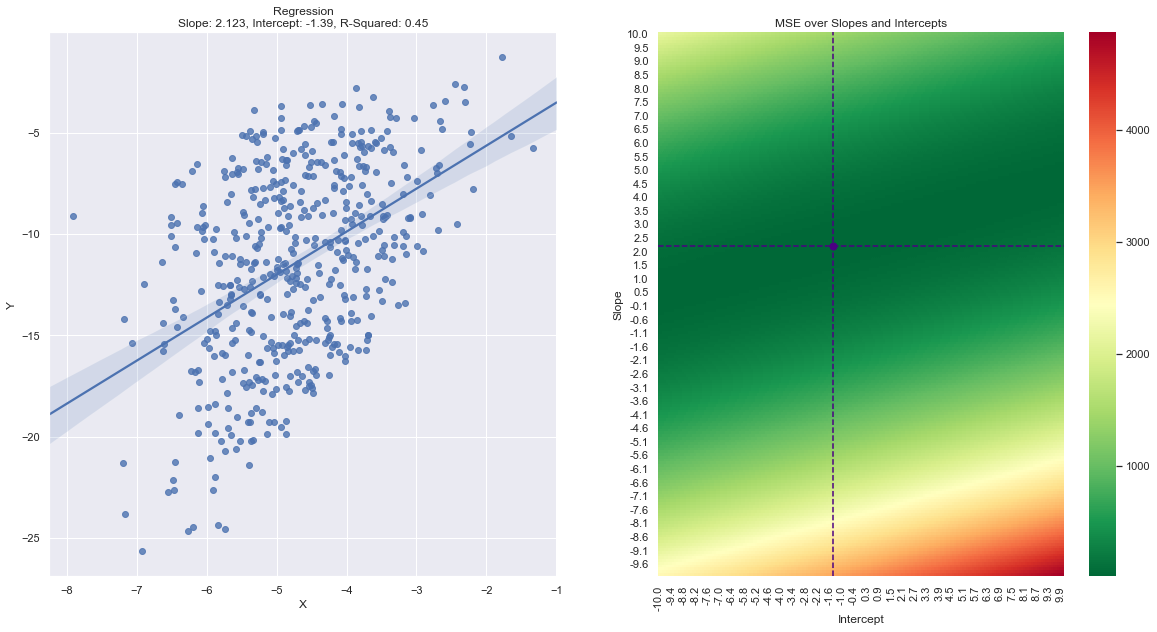

In [8]:
#Set Limits
increment = 0.1
slopes = [-10,10]
numslopes = (slopes[1]-slopes[0])/increment
intercepts = [-10,10]
numinter = (intercepts[1]-intercepts[0])/increment

#Get Data
X = np.random.randn(500)-2*np.random.randn(1)[0]
Y = list(map(lambda x: np.random.uniform(1,4)*x + np.random.randn(1)[0], X))
data = getHMData(slope=slopes,intercept=intercepts,X=X,Y=Y,step=increment)

#Format Labels
data = data.set_index(np.linspace(slopes[0],slopes[1],int(numslopes)).round(1))
data.columns = np.linspace(intercepts[0],intercepts[1],int(numinter)).round(1)

#Heat Map of MSE
fig, axs = plt.subplots(ncols=2,figsize=(20,10))
sns.heatmap(data.iloc[::-1,:],cmap="RdYlGn_r",ax = axs[1]).set(title='MSE over Slopes and Intercepts')
axs[1].set(xlabel='Intercept',ylabel='Slope')

#Regression Plot
sns.regplot(x='X',y='Y',data=pd.DataFrame({'X':X,'Y':Y}), ax = axs[0])
slope, intercept, r_value, p_value, std_err = stats.linregress(X, Y)
title = ('Regression\nSlope: '+str(slope.round(3))+', Intercept: '+
         str(intercept.round(3))+', R-Squared: '+str(r_value.round(3)))
axs[0].set_title(title)

#Plot Over Heatmap
axs[1].hlines([slope*-10+100], *axs[1].get_xlim(),linestyles='dashed',colors='indigo')
axs[1].vlines([intercept*10+100], *axs[1].get_ylim(),linestyles='dashed',colors='indigo')
axs[1].scatter(intercept*10+100,slope*-10+100,zorder=10,c='indigo',s=50)

## Your turn to solve a problem.

The below code will generate for you 3 sets of values: 'X1','X2' - Predictors, 'Y' - Target
You will need to generate a regression. Then, you should check the predictors to see which one is significant. After this, you will need to re-run the regression and confirm if the data satisfies our regression assumption. Finally, you should create a seaborn plot of your regression.

In [ ]:
Xs, Y = make_regression(n_samples=300, n_features=2, n_informative=1, noise=1)
data = pd.DataFrame(np.column_stack([Xs,Y]), columns=['X1','X2','Y'])

In [ ]:
#Regress
reg = smf.ols(formula='Y ~ X1+X2', data=pd.DataFrame({'X1':data['X1'],'X2':data['X2'],'Y':Y})).fit()
confint = pd.DataFrame(reg.conf_int())
pvalues = pd.DataFrame({'P-Value':reg.pvalues.round(7)})
reg.bic
print(pvalues)
print(confint)

In [ ]:
reg = smf.ols(formula='Y ~ X', data=pd.DataFrame({'X':data['X2'],'Y':Y})).fit()

In [ ]:
sns.residplot(x='X',y='Y',data=pd.DataFrame({'X':data['X2'],'Y':Y})).set_title('Residual Plot')

In [ ]:
residuals = reg.resid
predicted = reg.predict(pd.DataFrame({'X':data['X2'],'Y':Y}))

In [ ]:
sns.relplot(x='Predicted',y='Residuals',data=pd.DataFrame({'Predicted':predicted,'Residuals':residuals}))

In [ ]:
sns.relplot(x='Predicted',y='Observations',data=pd.DataFrame({'Predicted':predicted,'Observations':Y}))

In [ ]:
fig = sm.qqplot(residuals, line='45')